## Contents
* [Original Image](#original-image)
* [VerticalFlip](#vertical-flip)
* [HorizontalFlip](#horizontal-flip)
* [Flip](#flip)
* [Resize](#resize)
* [CenterCrop](#center-crop)
* [CenterCrop + FilterBboxes](#center-crop-filter-bboxes)
* [CenterCrop + FilterBboxes with min_area ](#center-crop-filter-bboxes-min-area)
* [RandomCrop](#random-crop)
* [Crop](#crop)
* [LongestMaxSize](#longest-max-size)
* [RandomScale](#random-scale)
* [Filtering bounding boxes by visibility](#filter-bbox-by-visibility)

In [1]:
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Flip,
    LongestMaxSize,
    RandomScale,
    FilterBboxes,
    Compose,
    convert_bboxes_to_albumentations,
    filter_bboxes_by_visibility,
    denormalize_bbox,
)

In [2]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_idx_to_name, color=BOX_COLOR, thickness=2):
    height, width = img.shape[:2]
    bbox = denormalize_bbox(bbox, height, width)
    x_min, y_min, x_max, y_max, class_idx = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_idx]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(img, bboxes, category_id_to_name):
    img = img.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox, category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [4]:
image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')

In [5]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = [
    {'bbox': [366.7, 80.84, 132.8, 181.84], 'category_id': 18},
    {'bbox': [5.66, 138.95, 147.09, 164.88], 'category_id': 17},
]
category_id_to_name = {17: 'cat', 18: 'dog'}
coco_bboxes = [ann['bbox'] + [ann['category_id']] for ann in annotations]

# Convert bounding boxes from the COCO format to the format used by albumentations.
bboxes = convert_bboxes_to_albumentations(image.shape, coco_bboxes, source_format='coco')

## Original image <a class="anchor" id="original-image"></a>

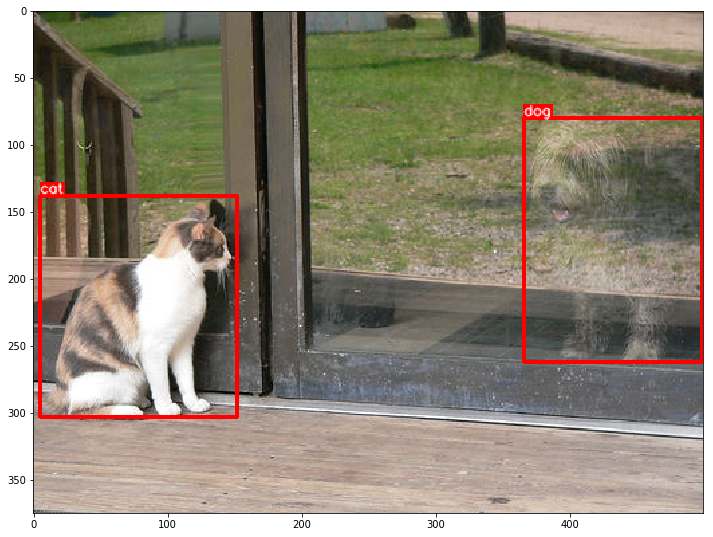

In [6]:
visualize(image, bboxes, category_id_to_name)

## VerticalFlip <span id='vertical-flip'></span>

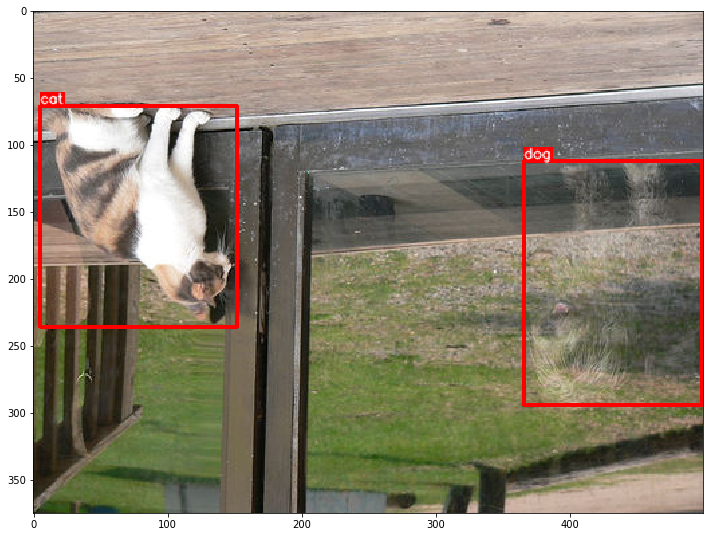

In [7]:
aug = VerticalFlip(p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## HorizontalFlip <span id='horizontal-flip'></span>

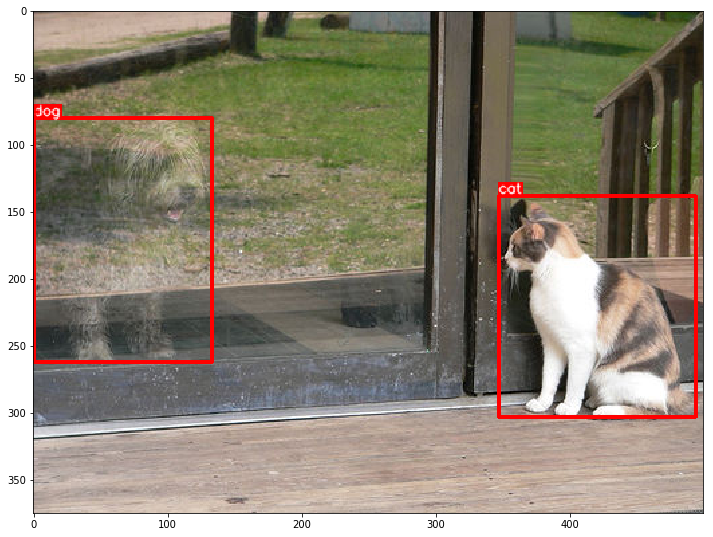

In [8]:
aug = HorizontalFlip(p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## Flip <span id='flip'></span>

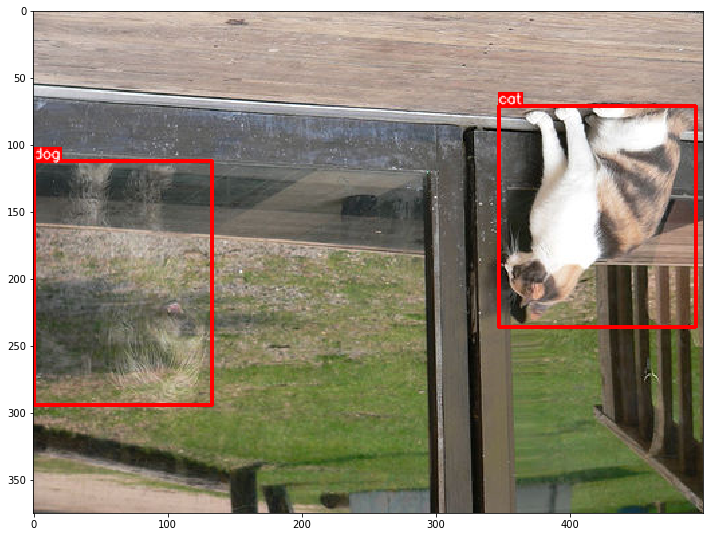

In [9]:
aug = Flip(p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## Resize <span id='resize'></span>

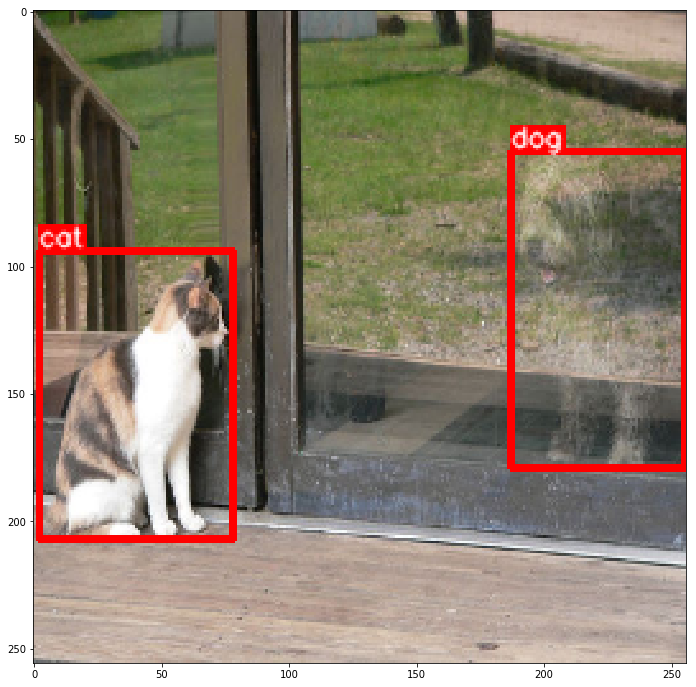

In [10]:
aug = Resize(p=1, height=256, width=256)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## CenterCrop <span id='center-crop'></span>

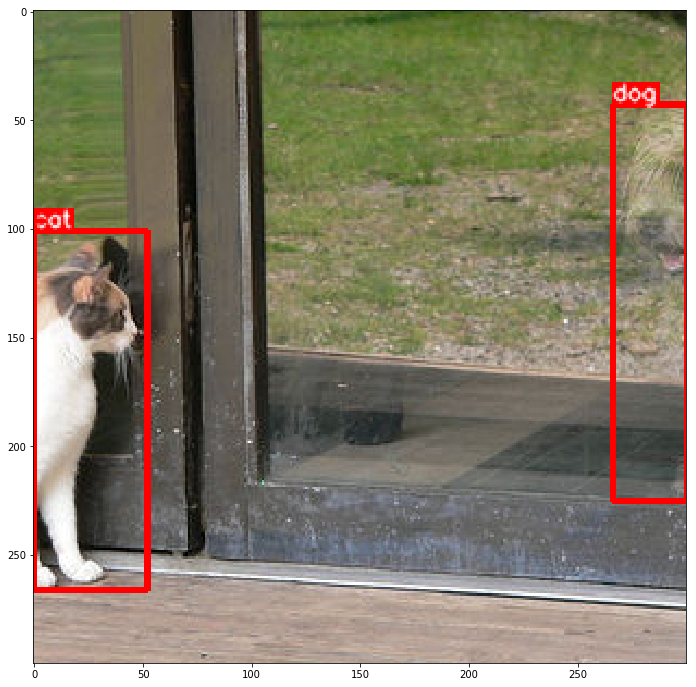

In [11]:
aug = CenterCrop(300, 300, p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## CenterCrop + FilterBboxes <span id='center-crop-filter-bboxes'></span>

Number of bboxes before augmentation: 2
Number of bboxes after augmentation: 1


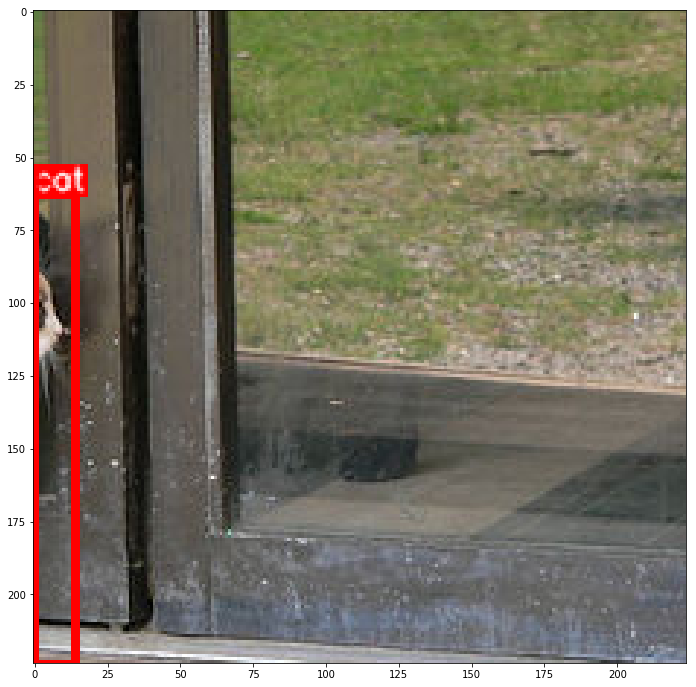

In [12]:
# You can use `FilterBboxes` to remove bounding boxes that lie outside of the visible area
aug = Compose([CenterCrop(224, 224, p=1), FilterBboxes()])
augmented = aug(image=image, bboxes=bboxes)
print('Number of bboxes before augmentation: {}'.format(len(bboxes)))
print('Number of bboxes after augmentation: {}'.format(len(augmented['bboxes'])))
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## CenterCrop + FilterBboxes with min_area <span id='center-crop-filter-bboxes-min-area'></span>

Number of bboxes before augmentation: 2
Number of bboxes after augmentation: 0


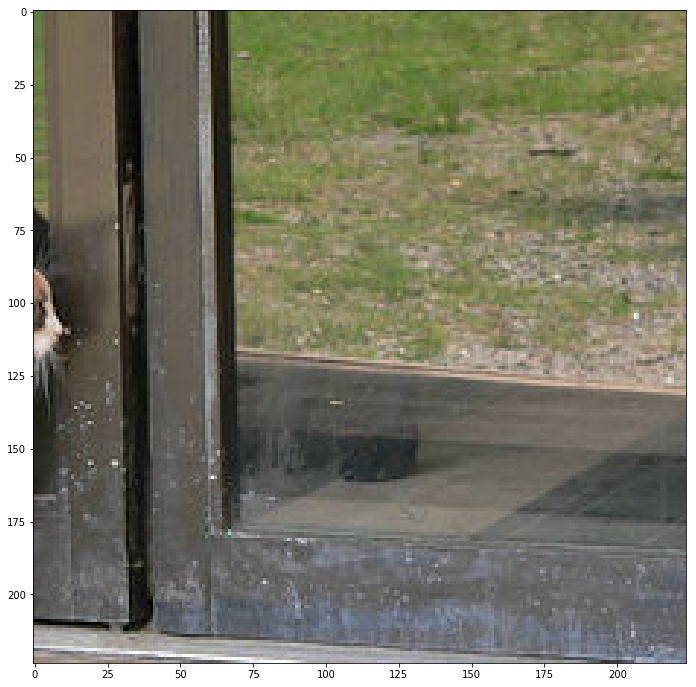

In [13]:
# You can also use `FilterBboxes` to remove bounding boxes 
# whose area in pixels is under the specified threshold

# The area of the bounding box for `cat` is about 2361 pixels,
# so it will be removed by `FilterBboxes`
aug = Compose([CenterCrop(224, 224, p=1), FilterBboxes(min_area=4000)])

augmented = aug(image=image, bboxes=bboxes)
print('Number of bboxes before augmentation: {}'.format(len(bboxes)))
print('Number of bboxes after augmentation: {}'.format(len(augmented['bboxes'])))
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## RandomCrop <span id='random-crop'></span>

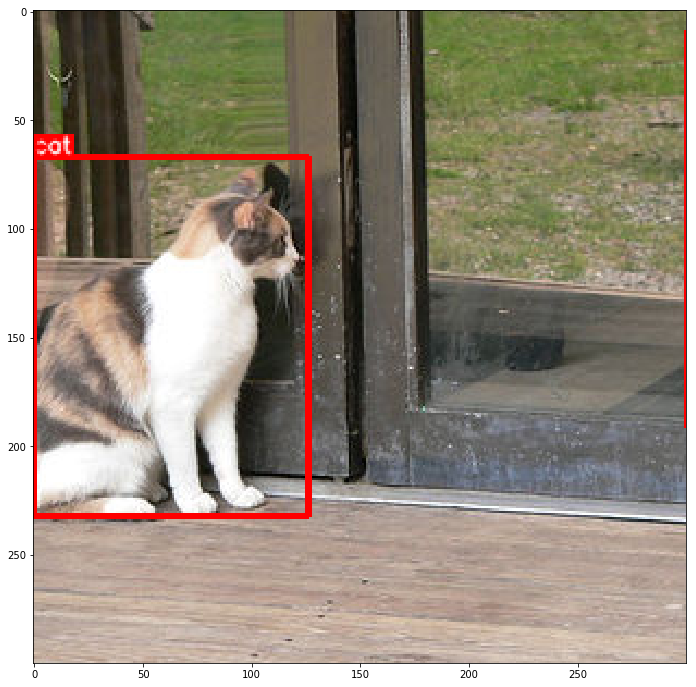

In [14]:
aug = RandomCrop(300, 300, p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## Crop <span id='crop'></span>

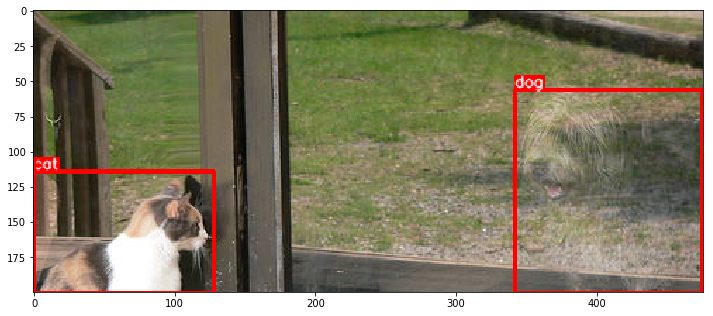

In [15]:
aug = Crop(24, 24, 500, 224, p=1)
augmented = aug(image=image, bboxes=bboxes)
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## LongestMaxSize <span id='longest-max-size'></span>

Image size before augmentation: (375, 500)
Image size after augmentation: (768, 1024)


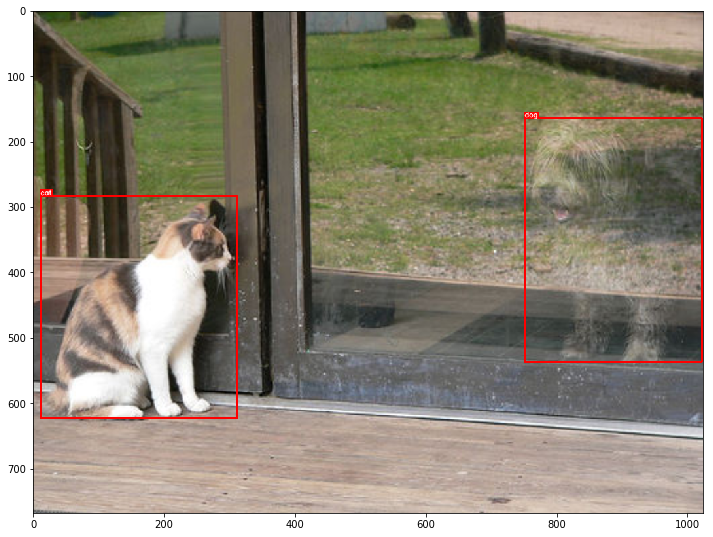

In [16]:
aug = LongestMaxSize(p=1)
augmented = aug(image=image, bboxes=bboxes)
print('Image size before augmentation: {}'.format(image.shape[:2]))
print('Image size after augmentation: {}'.format(augmented['image'].shape[:2]))
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## RandomScale <span id='random-scale'></span>

Image size before augmentation: (375, 500)
Image size after augmentation: (359, 478)


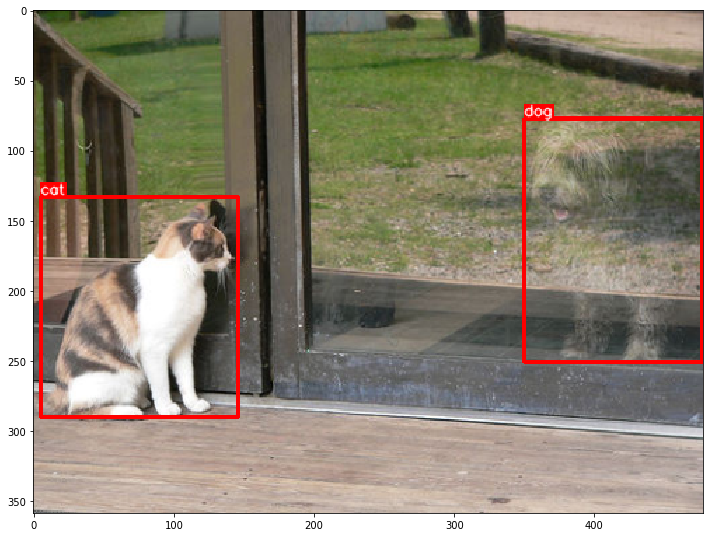

In [17]:
aug = RandomScale(p=1)
augmented = aug(image=image, bboxes=bboxes)
print('Image size before augmentation: {}'.format(image.shape[:2]))
print('Image size after augmentation: {}'.format(augmented['image'].shape[:2]))
visualize(augmented['image'], augmented['bboxes'], category_id_to_name)

## Filtering bboxes by visibility <span id='filter-bbox-by-visibility'></span>

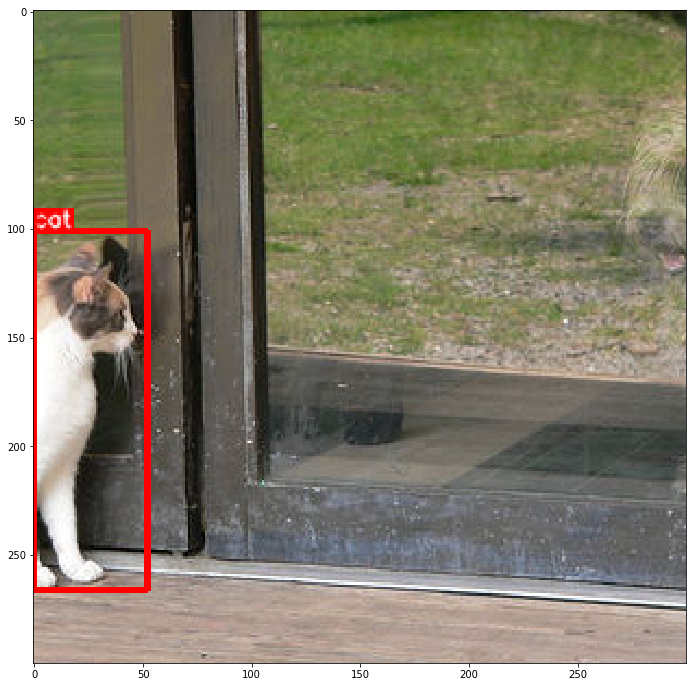

In [18]:
# The `filter_bboxes_by_visibility` function filters bounding boxes and returns
# only those boxes whose visibility after transformation is above the threshold.
aug = CenterCrop(300, 300, p=1)
augmented = aug(image=image, bboxes=bboxes)

# Visibility of the transformed bbox for `dog` is about 0.25 (that means that
# the area of the transformed bbox is about 25% of the area of the original bbox),
# so it will be removed by `filter_bboxes_by_visibility`. 
# Visibility of the transformed bbox for `cat` is about 0.36,
# so it will be kept.
filtered_bboxes = filter_bboxes_by_visibility(image, bboxes, augmented['image'], augmented['bboxes'], threshold=0.3)
visualize(augmented['image'], filtered_bboxes, category_id_to_name)